In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [ ]:

!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 2.4 kB/s 
     |████████████████████████████████| 454 kB 63.6 MB/s 
     |████████████████████████████████| 3.0 MB 38.3 MB/s 
     |████████████████████████████████| 2.9 MB 38.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalli

In [ ]:
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)


In [ ]:

# SETTING UP THE GENERATORS 

# IMAGE-GENERATORS ACCEPTS THE ORIGINAL DATA,RANDOMLY TRANSFORMING IT AND RETURN ONLY THE NEW TRANSFORMED DATA. [AUGMENTATION]

train_path                  = '/content/drive/MyDrive/ttv/train'
valid_path                  = '/content/drive/MyDrive/ttv/val'
test_path                   = '/content/drive/MyDrive/ttv/test'


# DIMENSION OF IMAGE 
image_size = 224

# THE IMAGE GENERATOR [KERAS]
datagen = ImageDataGenerator(
    rotation_range          = 180,
    width_shift_range       = 0.1,
    height_shift_range      = 0.1,
    zoom_range              = 0.1,
    horizontal_flip         = True,
    vertical_flip           = True,
    fill_mode               = 'nearest',
    preprocessing_function  = tensorflow.keras.applications.mobilenet.preprocess_input
    )

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=80)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=10)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=10,
                                            shuffle=False)


Found 918 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 111 images belonging to 4 classes.


In [ ]:
# MOBILENET ARCHITECTURE 
# MOBILENET IS A CNN ARCHITECTURE FOR IMAGE CLASSIFICATION . IT IS FAST AND CUSTOMIZABLE . 
# USES DEPTH WISE SEPERABLE CONVOLUTION

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

mobile.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [ ]:

# MODIFY THE MOBILENET

#--EXCLUDE LAST 6 LAYERS
x = mobile.layers[-6].output
#--CREATE A DENSE LAYER FOR PREDICTION OF 4 CLASSES 
x = Dropout(0.25)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

#--LAST 23 LAYERS WILL BE TRAINED AND FREEZING THE WEIGHTS OF REST
for layer in model.layers[:-23]:
    layer.trainable = False

model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
                             metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# CLASS SENSITIVITY , HERE PSORIASIS CLASS IS THE MOST SENSITIVE

class_weights={
    0: 3.0,   # PSORIASIS
    1: 1.5,   # MEASLES
    2: 2.0,   # MELANOMA
    3: 2.4,   # RINGWORM
}


In [ ]:
from datetime import datetime
def get_current_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    return str(current_time)
print(get_current_time())


Current Time = 00:12:15
00:12:15


### Train the Model

In [ ]:
#######################################################################################
filepath = "/content/drive/MyDrive/Skin Disease detection 2/models/model-"+get_current_time()+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, 
                                class_weight=class_weights,
                                validation_data=valid_batches,
                                epochs=30, verbose=1,
                                callbacks=callbacks_list)


Current Time = 04:11:35


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 6.1976 - categorical_accuracy: 0.5588 - top_2_accuracy: 0.7941 - top_3_accuracy: 0.9412 
Epoch 00001: val_top_3_accuracy improved from -inf to 0.78378, saving model to /content/drive/MyDrive/Skin Disease detection 2/models/model-04:11:35.h5
12/12 [==============================] - 322s 27s/step - loss: 6.1976 - categorical_accuracy: 0.5588 - top_2_accuracy: 0.7941 - top_3_accuracy: 0.9412 - val_loss: 59.2701 - val_categorical_accuracy: 0.2703 - val_top_2_accuracy: 0.5495 - val_top_3_accuracy: 0.7838 - lr: 0.0100
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 1.7122 - categorical_accuracy: 0.7059 - top_2_accuracy: 0.8965 - top_3_accuracy: 0.9706
Epoch 00002: val_top_3_accuracy did not improve from 0.78378
12/12 [==============================] - 85s 7s/step - loss: 1.7122 - categorical_accuracy: 0.7059 - top_2_accuracy: 0.8965 - top_3_accuracy: 0.9706 - val_loss: 48.3578 - val_categorical_accuracy: 

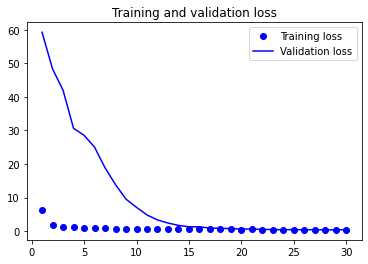

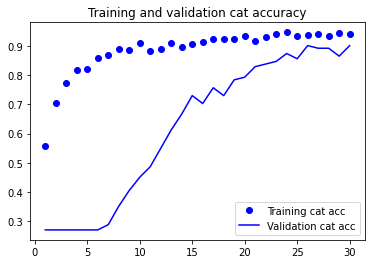

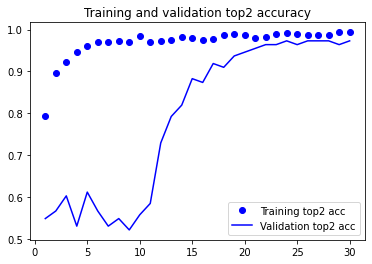

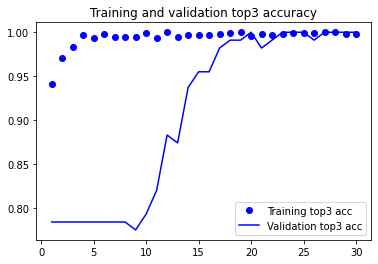

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Evaluate the model using the val set

In [ ]:
# Here the best epoch will be used.
model.load_weights('/content/drive/MyDrive/ttv/model.h5')


In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

[]

In [ ]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches) #evaluate_generator

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

12/12 [==============================] - 31s 3s/step - loss: 0.4408 - categorical_accuracy: 0.8468 - top_2_accuracy: 0.9820 - top_3_accuracy: 0.9910
val_loss: 0.44082513451576233
val_cat_acc: 0.8468468189239502
val_top_2_acc: 0.9819819927215576
val_top_3_acc: 0.9909909963607788


In [ ]:
yhat = model.predict(test_batches[0])

print(yhat)

[[2.4912968e-01 5.1083360e-03 1.6037281e-01 5.8538914e-01]
 [9.6456236e-01 2.4226440e-04 8.6617836e-04 3.4329176e-02]
 [9.9838281e-01 4.1598568e-04 6.3747124e-05 1.1374085e-03]
 [9.5953619e-01 7.4925707e-03 8.8789820e-04 3.2083306e-02]
 [7.5570130e-01 4.3164715e-03 1.8396758e-02 2.2158547e-01]
 [9.9992967e-01 4.0921364e-08 6.5627304e-08 7.0178736e-05]
 [9.9790394e-01 6.7398345e-05 6.1602608e-05 1.9670329e-03]
 [9.7016013e-01 7.7195914e-04 6.8949922e-03 2.2172919e-02]
 [9.9643755e-01 6.4735749e-04 6.5912020e-05 2.8491635e-03]
 [6.6180485e-01 1.5342004e-05 3.8208887e-05 3.3814165e-01]]


### Create a Confusion Matrix

In [ ]:
# Get the labels of the test images.
# Note that cats and dogs are in seperate folders therefore
# the code below can get the labels depending on the folder the image is in.

test_labels = test_batches.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3], dtype=int32)

In [ ]:
# Print the label associated with each class
test_batches.class_indices

{'Psoriasis': 0, 'measles': 1, 'melanoma': 2, 'ringworm': 3}

In [ ]:
# make a prediction
predictions = model.predict_generator(test_batches, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
12/12 [==============================] - 7s 570ms/step


In [ ]:
predictions.shape

(111, 4)

In [ ]:
import pandas as pd
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [ ]:
test_labels.shape

(111,)

In [ ]:
# argmax returns the index of the max value in a row
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'Psoriasis': 0, 'measles': 1, 'melanoma': 2, 'ringworm': 3}

Confusion matrix, without normalization
[[27  1  0  3]
 [ 6 16  0  2]
 [ 2  0 28  0]
 [ 5  0  0 21]]


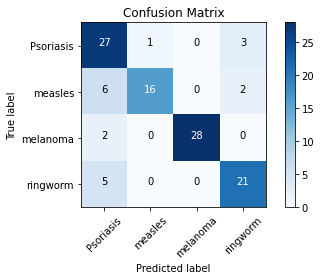

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.

cm_plot_labels = ['Psoriasis', 'measles', 'melanoma', 'ringworm']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

### Install Tensorflow.js

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.5 MB/s 


### Convert the model from Keras to Tensorflowjs
The conversion code below no longer works in kaggle kernels. I've left it in for reference. 

In order to convert this model the workaround is as follows:<br>
1. Recreate the model using native Keras.<br>
2. Use the command line conversion process to convert the model from Keras to Tensorflowjs.<br>
Here's how to do that: https://www.youtube.com/watch?v=Kc2_x6pBYGE

The above steps can be done in a kaggle kernel quite easily. Tensorflowjs is still fairly new so these type of bugs are not unusual.

In [ ]:
# create a directory to store the model files
import os
os.mkdir('/content/drive/MyDrive/Skin Disease detection 2/tfjs_dir-'+ get_current_time())


Current Time = 00:15:30


In [ ]:
# convert to Tensorflow.js
import tensorflowjs as tfjs

# Error
# AttributeError: module 'tensorflow.python.data.ops.dataset_ops' 
    # has no attribute 'UnaryDataset'

tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/Skin Disease detection 2/tfjs_dir-00:15:30')